/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


[[512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [512, 256], [51

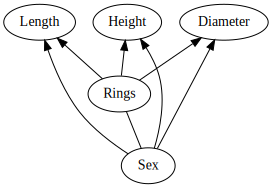

In [1]:
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
from pycausal.pycausal import pycausal as pc
from collections import defaultdict
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text
from pycausal import prior as p
import itertools
import pydot
from IPython.display import SVG
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

def examine_graph_continuous(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               )
    return tetrad.getTetradGraph()

def examine_graph_mixed(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 5,
           structurePrior = 1.0, maxDegree = -1, faithfulnessAssumed = True, verbose = True)

    return tetrad.getTetradGraph()

def examine_graph_discrete(df, prior = None):
    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'bdeu', priorKnowledge = prior, dataType = 'discrete',
               structurePrior = 1.0, samplePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()

def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

def make_categorical(df, complete_df, categoricals):   
    retval = None
    for key in df.columns:
        if retval is not None:
            if key in categoricals:
                retval = np.concatenate((retval, to_categorical(df[key], len(complete_df[key].unique()))), axis = 1)
            else:
                retval = np.concatenate((retval, df[key].values[...,np.newaxis]), axis = 1)
        else:
            if key in categoricals:
                retval = to_categorical(df[key], len(complete_df[key].unique()))
            else:
                retval = df[key]
    return retval

def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    #x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        #x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model

def get_bic(df, prior, penalty = 2):

    tetrad.run(algoId = 'fges', dfs = df, scoreId = 'cond-gauss-bic', 
           priorKnowledge = prior, dataType = 'mixed', numCategoriesToDiscretize = 4,
           structurePrior = 1.0, maxDegree = 3, faithfulnessAssumed = True, verbose = True)
    
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC

num_models = 100     
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()

inputs = ["Sex", "Length", "Diameter"]
target =  ["Height"]

inputs = ["Sex", "Length", "Diameter", "Height"]
target =  ["Rings"]
categoricals = ['Sex'] 


df = pd.read_csv('~/Desktop/Kaggle/abalone.data', names = ["Sex", "Length", "Diameter", "Height", "Rings"], usecols = [0, 1, 2, 3, 8])
label_encoder_list = []
#one_hot = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for i,col in enumerate(['Sex']):
    label_encoder_list.append(LabelEncoder())
    df[col] = label_encoder_list[i].fit_transform(df[col].values)
tempForbid = p.ForbiddenWithin(['Diameter', 'Height', 'Length'])
temporal = [['Sex', 'Rings'], tempForbid]
prior = p.knowledge(requiredirect= [('Sex', 'Height'),('Sex', 'Diameter'), ('Sex', 'Length')],
                   addtemporal = temporal
                   )

g = examine_graph_mixed(df[inputs + target], prior = prior)
dot_str = pc.tetradGraphToDot(g)
graphs = pydot.graph_from_dot_data(dot_str)
svg_str = graphs[0].create_svg()

known_conx = set({})
for i in tetrad.getEdges():
    if ' --> ' in i:
        known_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))


prior = p.knowledge(requiredirect =  list(map(list, known_conx)),)

n_holdout = 1000
df['Rings'] = normalize(df['Rings'])


models = []
model_names = []


original_df = df.copy()
randomize = False
if randomize:
    layers = [256, 512, 1024, 2048, 4096]
    for i in range(num_models):
        network = []
        for j in range(3):
            network.append(layers[random.randint(0,len(layers) -1)])
        models.append(network)
        model_names.append('temp/random' + str(i))
    print(models, model_names)    
else:
    model_layers = [512,256]
    for i in range(num_models):
        models.append(model_layers)
        model_names.append('temp/abalone' + str(i))

print(models, model_names)
SVG(svg_str)

In [2]:
df.head()

,Sex,Length,Diameter,Height,Rings
0,2,0.455,0.365,0.095,0.500000
1,2,0.350,0.265,0.090,0.214286
2,0,0.530,0.420,0.135,0.285714
3,2,0.440,0.365,0.125,0.321429
4,1,0.330,0.255,0.080,0.214286


In [3]:
bestMSE = []
bestBIC = []
bestCOMBO = []

for t in range(10):
    # let's split our df into two by race.  Let's see what happens if we 
    df = original_df.copy()

    #df_test = df[df['Height'] < 0.13].copy()

    '''
    Good ones
    #df_test = df.nsmallest(n_holdout, 'Height').copy()
    #df_test = df.nlargest(n_holdout, 'Height').copy()
    df_test = df.nsmallest(n_holdout, 'Length').copy()
    df_test = df.nlargest(n_holdout, 'Length').copy()
    df_test = df[df['Sex'] == 0].copy()
    '''

    '''
    bad ones
    df_test = df[df['Sex'] == 1][:n_holdout].copy()
    df_test = df[df['Sex'] == 2].copy()
    df_test = df[df['Sex'] == 1].copy()
    '''
    #df_test = df.nsmallest(n_holdout, 'Length').copy()

    holdout = 800
        #df_test = df[df['charges'] > 0.54].copy()
    continuous = ["Length",  "Diameter", "Height", "Rings"]
    
    
    small = random.randint(0,1)
    cont = random.randint(0, len(continuous) - 1)
    if small == 0:
        df_test = df.nsmallest(holdout, continuous[cont])
    else:
        df_test = df.nlargest(holdout, continuous[cont])
    
    print(t, small, continuous[cont])

    '''
        end_idx = len(df) - holdout
    cont = random.randint(0, len(continuous) - 1)
    start_idx = random.randint(0, end_idx)
    print(t, "Doing range:",start_idx, start_idx + holdout, "and ", continuous[cont])
    df_test = df.nlargest(len(df) - start_idx, continuous[cont]).nsmallest(holdout, continuous[cont])
    '''


    
    df.drop(df_test.index, inplace = True)
    df_test.reset_index(inplace = True)
    df.sample(frac= 1).reset_index(inplace = True) # this will shuffle and reset index

    x_test = df_test[inputs]
    y_test = df_test[target]

    causal_split = 0.2
    val_split = 0.2
    train_split = 1 - (causal_split + val_split)

    x_causal = df[inputs][-int(causal_split * len(df)) :]
    y_causal = df[target][-int(causal_split * len(df)) :]

    x_val = df[inputs][int(train_split * len(df)):-int(causal_split * len(df))]
    y_val = df[target][int(train_split * len(df)):-int(causal_split * len(df))]

    x_train = df[inputs][:int(train_split * len(df))]
    y_train = df[target][:int(train_split * len(df))]
    len(x_causal), len(y_causal), len(x_val), len(y_val), len(x_train), len(y_train)



    x_test_NN = make_categorical(x_test, original_df, categoricals)
    x_causal_NN = make_categorical(x_causal, original_df, categoricals)
    x_val_NN = make_categorical(x_val, original_df, categoricals)
    x_train_NN = make_categorical(x_train, original_df, categoricals)

    verbosity = 0


    for idx, model_name in enumerate(model_names):
        #print(model_name)

        if type(models[idx]) is list:
            #clear session
            keras.backend.clear_session() 
            #get model according to specification
            model = get_model(models[idx], [0.2] * len(models), np.shape(x_train_NN)[1])
            callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                         EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
            model.compile(optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
            #print(len(X), len(y))
            model.fit(x_train_NN, y_train, epochs = 20, validation_data = (x_val_NN, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
        else:
            models[idx].fit(X,y)




    generalization = []
    metrics = []
    proposed = []
    x_causal.reset_index(drop = True, inplace = True)

    for idx, model_name in enumerate(model_names):
        #print(model_name)
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]

        y_pred = model.predict(x_test_NN)
        generalization.append(mean_absolute_error(y_pred, y_test))

        #### CHECK FOR CAUSAL METRIC HERE
        y_causal_pred = model.predict(x_causal_NN)
        causal_targets = pd.DataFrame(y_causal_pred, columns = target)
        causal_targets.reset_index(drop=True, inplace = True)
        causal_df = x_causal.join(causal_targets)



        metrics.append(mean_absolute_error(y_causal_pred, y_causal))
        #print(x_causal.head)
        bic_pred = get_bic(causal_df, prior)
        #print(bic_pred, tetrad.getEdges())

        found_conx = set({})
        for i in tetrad.getEdges():
            if ' --> ' in i:
                found_conx.add((i.split(' --> ')[0], i.split(' --> ')[1]))
        found_conx

        if found_conx == known_conx:
            proposed.append(bic_pred)
        else:
            print("******Found an error")
            # for now just remove bad model.  Will need to add it to distance metric.
            metrics = metrics[:-1]
            generalization = generalization[:-1]
    total = normalize(metrics) + normalize(proposed)
    nbest = 10
    final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
    print("MSE = ", np.mean(final.nsmallest(nbest, 'metrics')['generalization']))
    print("BIC = ", np.mean(final.nsmallest(nbest, 'proposed')['generalization']))
    print("COMB = ",np.mean(final.nsmallest(nbest, 'combined')['generalization']))
    bestMSE.append(final.nsmallest(nbest, 'metrics')['generalization'])
    bestBIC.append(final.nsmallest(nbest, 'proposed')['generalization'])
    bestCOMBO.append(final.nsmallest(nbest, 'combined')['generalization'])
    

np.mean(bestMSE), np.mean(bestBIC), np.mean(bestCOMBO), np.std(bestMSE), np.std(bestCOMBO)

0 Doing range: 260 1060 and  Length
MSE =  0.06003164774232676
BIC =  0.051521575143028575
COMB =  0.0525941062580262
1 Doing range: 2715 3515 and  Rings
MSE =  0.04585834005874183
BIC =  0.04201337429854487
COMB =  0.04419861467342291
2 Doing range: 2158 2958 and  Rings
MSE =  0.03719587846792169
BIC =  0.045823541216818336
COMB =  0.043291774689086834
3 Doing range: 2104 2904 and  Length
MSE =  0.07866100218998535
BIC =  0.0806126060443265
COMB =  0.07957062395821726
4 Doing range: 624 1424 and  Height
MSE =  0.053694101499127476
BIC =  0.05791923519915768
COMB =  0.05372638959943184
5 Doing range: 3182 3982 and  Diameter
MSE =  0.0739168658416186
BIC =  0.07677133761612431
COMB =  0.0750425093977579
6 Doing range: 2378 3178 and  Height
MSE =  0.07589864767741943
BIC =  0.07955029775016009
COMB =  0.07721105653899056
7 Doing range: 1499 2299 and  Rings
MSE =  0.05951641482540539
BIC =  0.06655489756273372
COMB =  0.06377297743915447
8 Doing range: 3353 4153 and  Rings


KeyboardInterrupt: 

In [ ]:
#bestMSE = [0.009634, 0.005965, 0.006659, 0.008800, 0.006828, 0.005964, 0.008231, 0.008416, 0.007061, 0.007471]
np.mean(bestMSE), np.mean(bestBIC), np.mean(bestCOMBO)

In [ ]:
len(df_test) + len(x_train) + len(x_val) + len(x_causal), len(original_df)

In [ ]:
fig, ax = plt.subplots()
b,m = polyfit(proposed,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(proposed,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(proposed,generalization, '.')
plt.plot(proposed, b + m * np.array(proposed), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
b,m = polyfit(metrics,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(metrics,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(metrics,generalization, '.')
plt.plot(metrics, b + m * np.array(metrics), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


total = normalize(metrics) + normalize(proposed)
fig, ax = plt.subplots()
b,m = polyfit(total,generalization, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(total,generalization)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(total,generalization, '.')
plt.plot(total, b + m * np.array(total), '-')
ax.set_xlabel("MSE")
ax.set_ylabel("GEN")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


In [ ]:
nbest = 5
final = pd.DataFrame(np.stack((metrics, proposed, total, generalization), axis = 1), columns = ['metrics', 'proposed', 'combined', 'generalization'])
print("MSE = ", np.sum(final.nsmallest(nbest, 'metrics')['generalization']))
print("BIC = ", np.sum(final.nsmallest(nbest, 'proposed')['generalization']))
print("COMB = ",np.sum(final.nsmallest(nbest, 'combined')['generalization']))

In [ ]:
len(original_df)